In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import warnings; warnings.simplefilter('ignore')
import sys
import h5py
import pandas as pd
import seaborn as sns
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_ancillary
import jsm_visualize
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import evolve as ev
import galhalo as gh
import profiles as profiles
import config as cfg

In [3]:
plt.style.use('../../../SatGen/notebooks/paper1/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches
levelz = [1-0.99, 1-0.95, 1-0.68]

In [22]:
N_AB_sub_small = np.loadtxt('../../../misc/ForSebastian/N_AB_sub_small.dat')
logMvir = N_AB_sub_small[:,0]
c_h = N_AB_sub_small[:,1]
a50 = np.log10(N_AB_sub_small[:,2])
Nsub = np.log10(N_AB_sub_small[:,3])

In [23]:
# --- mask ---
mask = (logMvir >= 12.5) & (logMvir <= 14)

logMvir = logMvir[mask]
c_h     = c_h[mask]
a50     = a50[mask]
Nsub    = Nsub[mask]

# --- sort by increasing host mass ---
sort_idx = np.argsort(logMvir)

logMvir = logMvir[sort_idx]
c_h     = c_h[sort_idx]
a50     = a50[sort_idx]
Nsub    = Nsub[sort_idx]

In [24]:
from scipy.stats import binned_statistic
logMvir_bins = np.arange(12.5, 14.1, 0.1)

# ---- For y1 ----
a50_mean, bin_edges, _ = binned_statistic(logMvir, a50, statistic='mean', bins=logMvir_bins)
a50_std, _, _ = binned_statistic(logMvir, a50, statistic='std', bins=logMvir_bins)

# ---- For y2 ----
Nsub_mean, _, _ = binned_statistic(logMvir, Nsub, statistic='mean', bins=logMvir_bins)
Nsub_std, _, _ = binned_statistic(logMvir, Nsub, statistic='std', bins=logMvir_bins)

# bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

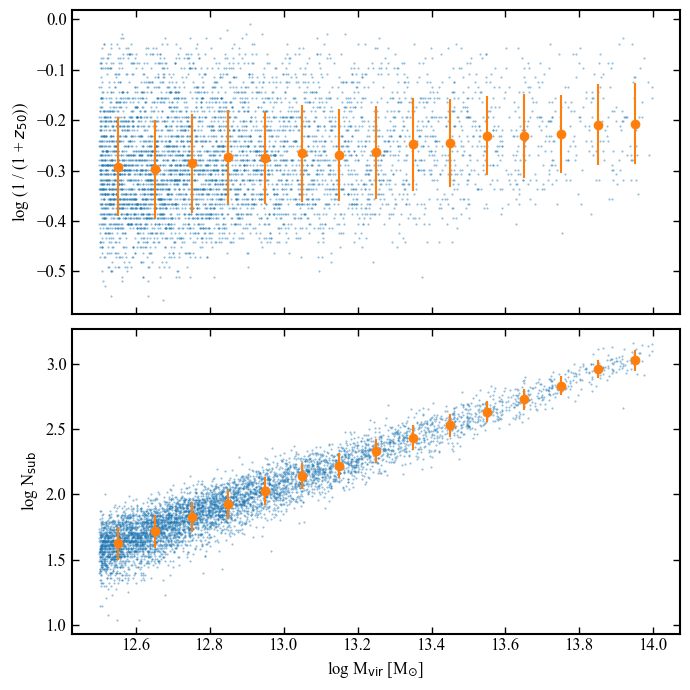

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(double_textwidth, double_textwidth), sharex=True)


ax[0].scatter(logMvir, a50, marker=".", s=1, alpha=0.5)
ax[1].scatter(logMvir, Nsub, marker=".", s=1, alpha=0.5)

ax[0].errorbar(bin_centers, a50_mean, yerr=a50_std, fmt="o", color="C1")
ax[1].errorbar(bin_centers, Nsub_mean, yerr=Nsub_std, fmt="o", color="C1")

# ax[0].plot(halo_smooth, a50_line(halo_smooth), color="k")
# ax[1].plot(halo_smooth, Nsub_line(halo_smooth), color="k")

ax[1].set_xlabel("log M$_{\\rm vir}$ [M$_{\\odot}$]")
ax[0].set_ylabel("log (1 / (1 + $z_{50}$))")
ax[1].set_ylabel("log N$_{\\rm sub}$")

plt.tight_layout()
plt.show()

In [26]:
from scipy.optimize import minimize

def fit_line_asym_errors(x, y, yerr_up, yerr_down, p0=(1.0, 0.0)):
    """
    Fit y = m x + b with asymmetric y-errors using weighted least squares.

    Parameters
    ----------
    x : array_like
        Independent variable
    y : array_like
        Dependent variable
    yerr_up : array_like
        Upper (positive) y-uncertainties
    yerr_down : array_like
        Lower (negative) y-uncertainties
    p0 : tuple, optional
        Initial guess for (m, b)

    Returns
    -------
    m, b : float
        Best-fit slope and intercept
    result : OptimizeResult
        Full scipy optimization result
    """

    x = np.asarray(x)
    y = np.asarray(y)
    yerr_up = np.asarray(yerr_up)
    yerr_down = np.asarray(yerr_down)

    def chi2(params):
        m, b = params
        y_model = m * x + b

        # Choose uncertainty based on which side of the point the model is on
        sigma = np.where(y_model > y, yerr_up, yerr_down)

        return np.sum(((y - y_model) / sigma) ** 2)

    result = minimize(chi2, p0, method="Nelder-Mead")

    m_best, b_best = result.x
    return m_best, b_best, result


In [27]:
halo_smooth = np.linspace(12.5, 14, 100)

m_a50, b_a50, res_a50 = fit_line_asym_errors(bin_centers, a50_mean, a50_std, a50_mean, p0=(0.5, 1.0))
def a50_line(log_Mvir):
    return m_a50*log_Mvir+b_a50

m_Nsub, b_Nsub, res_Nsub = fit_line_asym_errors(bin_centers, Nsub_mean, Nsub_std, Nsub_std, p0=(1, 1.0))
def Nsub_line(log_Mvir):
    return m_Nsub*log_Mvir+b_Nsub

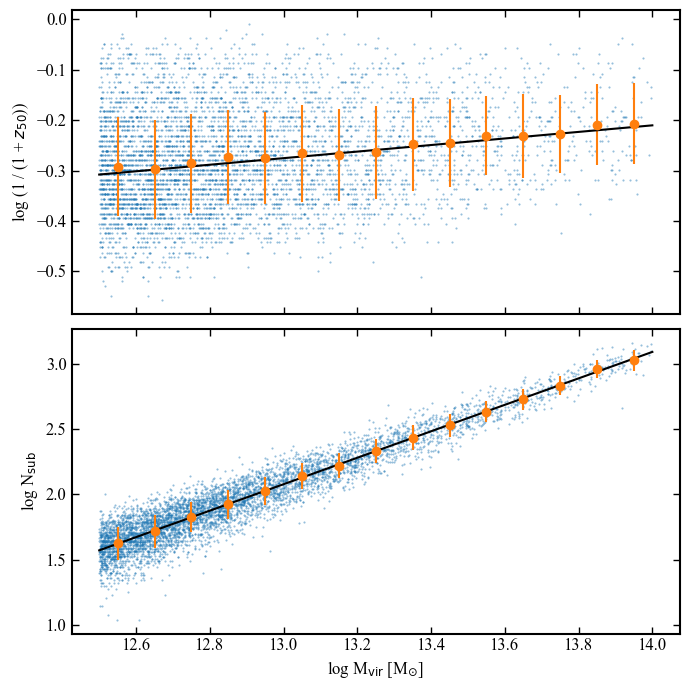

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(double_textwidth, double_textwidth), sharex=True)


ax[0].scatter(logMvir, a50, marker=".", s=1, alpha=0.5)
ax[1].scatter(logMvir, Nsub, marker=".", s=1, alpha=0.5)

ax[0].errorbar(bin_centers, a50_mean, yerr=a50_std, fmt="o", color="C1")
ax[1].errorbar(bin_centers, Nsub_mean, yerr=Nsub_std, fmt="o", color="C1")

ax[0].plot(halo_smooth, a50_line(halo_smooth), color="k")
ax[1].plot(halo_smooth, Nsub_line(halo_smooth), color="k")

ax[1].set_xlabel("log M$_{\\rm vir}$ [M$_{\\odot}$]")
ax[0].set_ylabel("log (1 / (1 + $z_{50}$))")
ax[1].set_ylabel("log N$_{\\rm sub}$")

plt.tight_layout()
plt.show()

In [32]:
SIM_df = pd.DataFrame({"log_Mhost": logMvir, "a_50": a50, "delta_a50": a50 - a50_line(logMvir), "Nsub": Nsub, "delta_Nsub": Nsub - Nsub_line(logMvir)})
SIM_df.to_csv("../../data/summary/SIM_summary.csv", index=False)

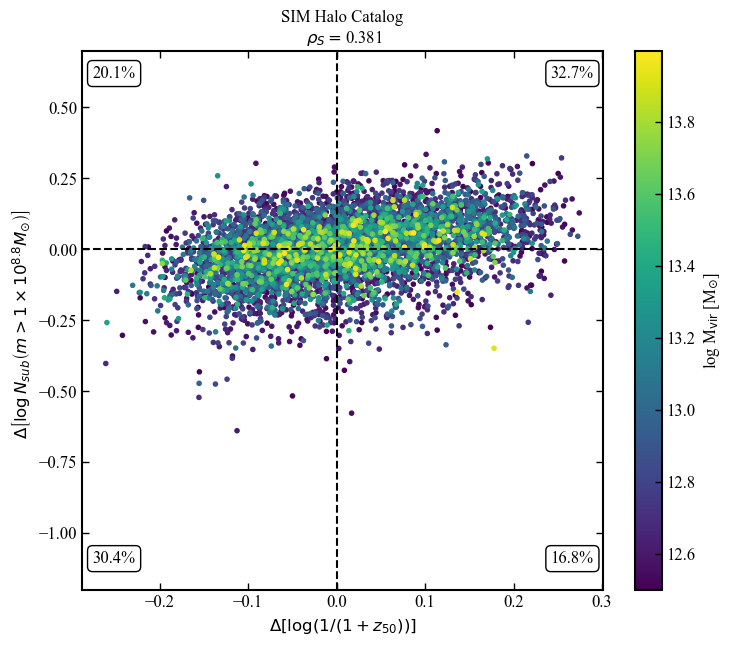

In [33]:
fig, ax = plt.subplots(figsize=(double_textwidth*1.2, double_textwidth))


ax.set_xlabel("$\\Delta [\\log (1/(1+z_{50}))] $")
ax.set_ylabel("$\\Delta \\left[\\log N_{sub} \\left(m > 1\\times10^{8.8} M_{\\odot} \\right) \\right]$  ")

ax.axhline(0, ls="--", color="k", zorder=11)
ax.axvline(0, ls="--", color="k", zorder=11)

qs, rho, pval = jsm_stats.quadrant_percentages_plot(SIM_df["delta_a50"], SIM_df["delta_Nsub"])
sm = ax.scatter(SIM_df["delta_a50"], SIM_df["delta_Nsub"], c=logMvir,marker=".")
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("log M$_{\\rm vir}$ [M$_{\\odot}$]")

ax.set_title("SIM Halo Catalog\n $\\rho_S =$"+rho)
ax.text(0.9, 0.95, qs[0], fontsize=12, transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="white"))
ax.text(0.9, 0.05, qs[1], fontsize=12, transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="white"))
ax.text(0.02, 0.05, qs[2], fontsize=12, transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="white"))
ax.text(0.02, 0.95, qs[3], fontsize=12, transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="white"))

ax.set_ylim(-1.2, 0.7)
plt.show()